findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


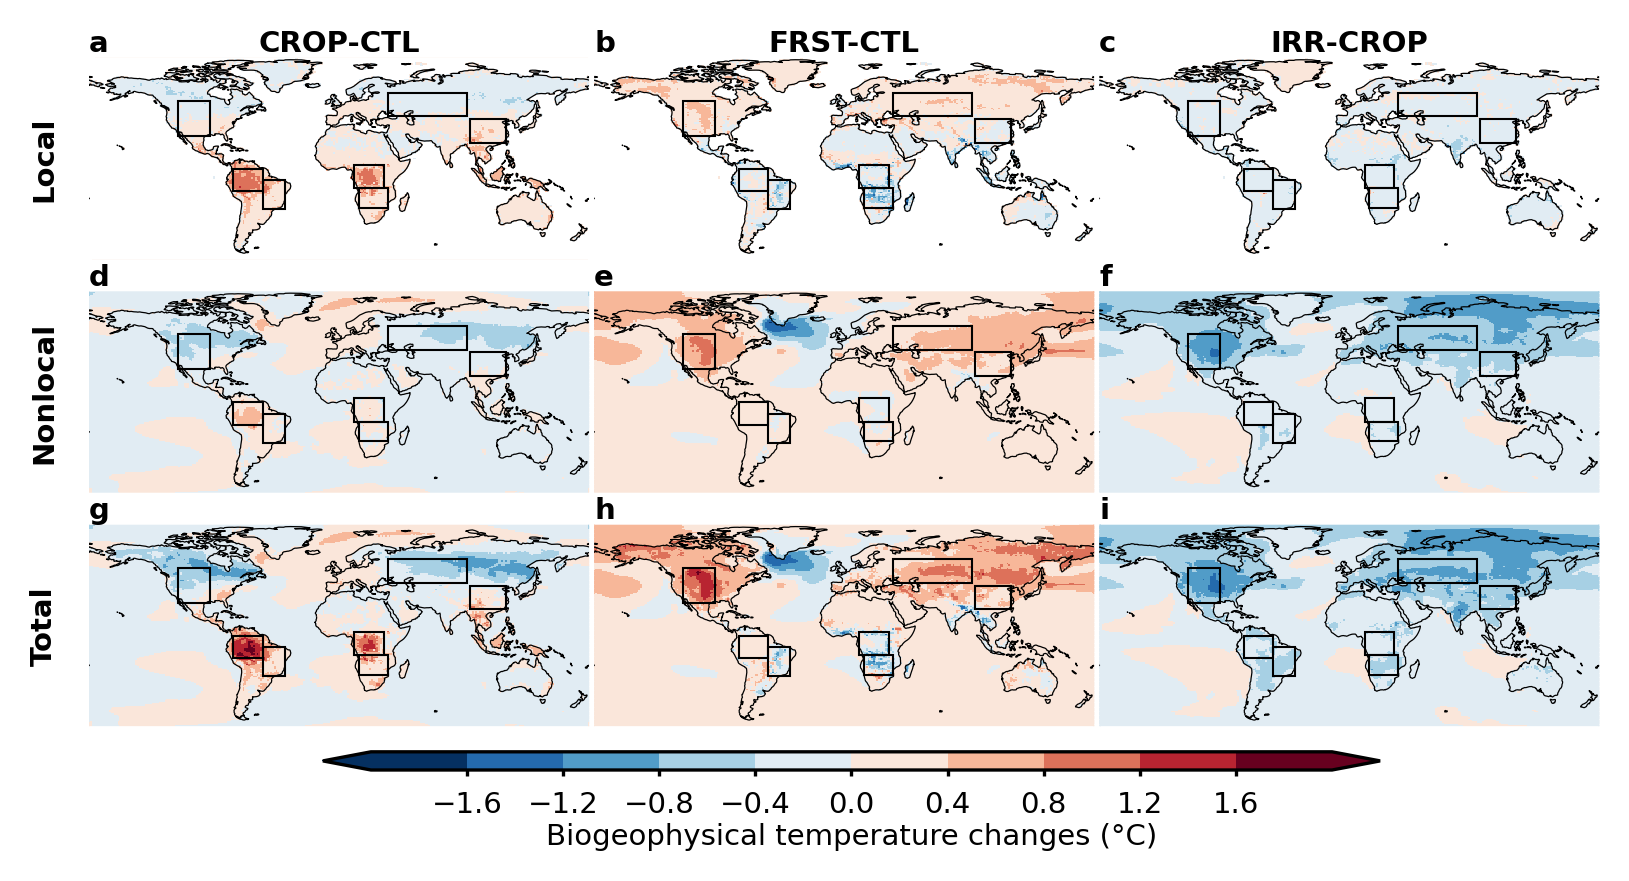

绘图完成，结果已保存到 /scratch/b/b380949/NC-BGP_temperature_changes_map_v2.pdf
文件大小: 11.08 MB


In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
from matplotlib import rcParams
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm
from matplotlib.patches import Polygon
import matplotlib.cm as cm

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 7

experiments = ['CROP-CTL', 'FRST-CTL', 'IRR-CROP']
variables = ['tas_local', 'tas_nonlocal', 'tas_total']
variable_labels = ['Local', 'Nonlocal', 'Total']

box_coords = [
    [(244,244,267,267,244), (29,54,54,29,29)],
    [(35,35,92,92,35), (43,60,60,43,43)],
    [(284,284,305,305,284), (-11,5,5,-11,-11)],
    [(11,11,32,32,11), (-9,8,8,-9,-9)],
    [(305,305,321,321,305), (-24,-3,-3,-24,-24)],
    [(14,14,35,35,14), (-23,-9,-9,-23,-23)],
    [(94,94,120,120,94), (24,41,41,24,24)]
]

def create_10level_cmap():
    # 从 "RdBu_r" 采样 10 个区分度高的颜色（蓝5 + 红5）
    cmap = cm.get_cmap('RdBu_r')
    colors = [cmap(i)[:3] for i in [0, 28, 56, 85, 113, 143, 170, 198, 226, 255]]
    return LinearSegmentedColormap.from_list('10level_cmap', colors, N=256)

cm_var = 1 / 2.54
fig_width = 16.5 * cm_var
fig_height = 7.7 * cm_var  # 更紧凑

fig = plt.figure(figsize=(fig_width, fig_height), dpi=300)
gs = fig.add_gridspec(6, 3, height_ratios=[1, 0.005, 1, 0.005, 1, 0.005], hspace=0.0, wspace=0.01)

axes = []
panel_labels = list("abcdefghi")
panel_idx = 0

for row in range(3):
    row_axes = []
    for col in range(3):
        ax = fig.add_subplot(gs[row*2, col], projection=ccrs.PlateCarree())
        ax.set_extent([-180, 180, -60, 85], ccrs.PlateCarree())
        ax.set_frame_on(False)
        # panel标注放在panel左上角外部
        fig.text(
            ax.get_position().x0 - 0.0,
            ax.get_position().y1 + 0.0,
            panel_labels[panel_idx],
            fontsize=7, fontweight='bold', ha='left', va='bottom'
        )
        panel_idx += 1
        row_axes.append(ax)
    axes.append(row_axes)

for col, exp in enumerate(experiments):
    axes[0][col].set_title(exp, fontsize=7, pad=1.5, fontweight='bold')

for row, label in enumerate(variable_labels):
    axes[row][0].text(-0.09, 0.5, label, transform=axes[row][0].transAxes,
                      fontsize=7, ha='center', va='center', rotation=90, fontweight='bold')

for col, exp in enumerate(experiments):
    ds = xr.open_dataset(f'/work/bm1147/b380949/web-monitoring/secP/ensemble/tas_ensemble/model_ens/model_ens/tas_{exp.lower()}_3models-ensemble.nc')
    ds1 = xr.open_dataset(f'/work/bm1147/b380949/web-monitoring/secP/ensemble/tas_ensemble/model_ens/model_ens/tas_frst-ctl_3models-ensemble.nc')    
    land_sea_mask = ds1['tas_local'].isel(time=0)

    for row, var in enumerate(variables):
        ax = axes[row][col]
        data = ds[var].isel(time=0)
        bounds = [-2, -1.6, -1.2, -0.8, -0.4, 0, 0.4, 0.8, 1.2, 1.6,2]
        norm = BoundaryNorm(bounds, 256)

        im = ax.pcolormesh(data.lon, data.lat, data,
                           transform=ccrs.PlateCarree(),
                           cmap=create_10level_cmap(),
                           norm=norm)

        if var == 'tas_local':
            ocean_mask = land_sea_mask.isnull()
            ocean_mask_np = ocean_mask.values
            white_overlay = np.full_like(ocean_mask_np, np.nan, dtype=float)
            white_overlay[ocean_mask_np] = 1
            ax.pcolormesh(data.lon, data.lat, white_overlay,
                          transform=ccrs.PlateCarree(),
                          cmap=LinearSegmentedColormap.from_list("white_only", ['white', 'white']),
                          vmin=0, vmax=1)

        ax.add_feature(cfeature.COASTLINE, linewidth=0.3)

        for box in box_coords:
            lon, lat = box
            poly = Polygon(list(zip(lon, lat)), closed=True,
                           transform=ccrs.PlateCarree(),
                           edgecolor='black', facecolor='none',
                           linewidth=0.5)
            ax.add_patch(poly)

        # Colorbar只加在最后一个panel后面
        if row == 2 and col == 2:
            cbar_ax = fig.add_subplot(gs[5, :])
            cbar_ax.set_position([
                cbar_ax.get_position().x0+0.12,
                cbar_ax.get_position().y0 - 0.03,
                cbar_ax.get_position().width*0.7,
                0.02
            ])
            cbar = plt.colorbar(
                plt.cm.ScalarMappable(norm=norm, cmap=create_10level_cmap()),
                cax=cbar_ax,
                orientation='horizontal',
                ticks=np.arange(-1.6, 2.0, 0.4),
                spacing='proportional',
                extend='both'
            )
            cbar.set_label('Biogeophysical temperature changes (°C)', fontsize=7, labelpad=1)
            cbar.ax.tick_params(labelsize=7, direction='out', length=1.5)
            cbar.ax.xaxis.set_ticks_position('bottom')
            cbar.ax.xaxis.set_label_position('bottom')

#output_path = '/work/bm1147/b380949/web-monitoring/secP/ensemble/tas_ensemble/model_ens/model_ens/NC-BGP_temperature_changes_map_v2.jpg'
output_path = '/scratch/b/b380949/NC-BGP_temperature_changes_map_v2.pdf'
            
plt.savefig(output_path, bbox_inches='tight', format='pdf', dpi=300)
plt.show()
plt.close()

print(f"绘图完成，结果已保存到 {output_path}")
print(f"文件大小: {os.path.getsize(output_path) / (1024 * 1024):.2f} MB")
